In [1]:
# === 1) Paths & imports ===
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Project root — CHANGE if your path differs
project_root = Path("/Users/v/Desktop/Visual/glaucoma_DL_project")

# Data paths
p24_path   = project_root / "data" / "uwhvf-master" / "p24d2.csv"                 # basic coordinates (x,y)
coord_path = project_root / "data" / "uwhvf-master" / "CSV" / "Coord_242.csv"     # annotated coordinates (X,Y,Cluster,LocID) — if available
feat_dir   = project_root / "data" / "features"                                    # X/Y npy
proc_dir   = project_root / "data" / "processed"                                   # meta

# Output dir for figures
fig_dir = project_root / "results" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

print("Project:", project_root)

Project: /Users/v/Desktop/Visual/glaucoma_DL_project


In [2]:
# === 2) Read coordinate files ===
coords_basic = pd.read_csv(p24_path)  # columns: x, y
print("Basic coords (p24d2.csv):", coords_basic.shape)
display(coords_basic.head())

# Try to read the annotated coord file if present
try:
    coords_full = pd.read_csv(coord_path)  # columns: X, Y, Cluster, LocID
    print("Annotated coords (Coord_242.csv):", coords_full.shape)
    display(coords_full.head())
    HAS_FULL = True
except Exception as e:
    print("Annotated Coord_242.csv not found. Proceeding with basic coordinates only.")
    HAS_FULL = False

Basic coords (p24d2.csv): (54, 2)


,x,y
0,-9,21
1,-3,21
2,3,21
3,9,21
4,-15,15


Annotated coords (Coord_242.csv): (54, 4)


,X,Y,Cluster,LocID
0,-9,21,1,1
1,-3,21,1,2
2,3,21,1,3
3,9,21,1,4
4,-15,15,1,5


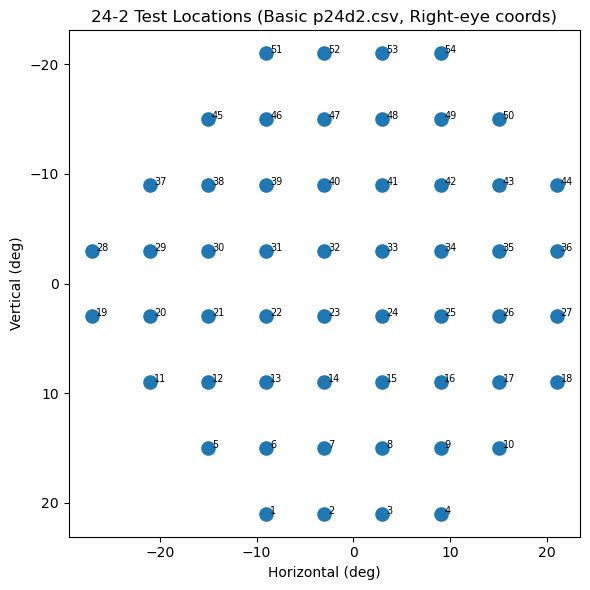

In [3]:
# === 3) Plot basic 24-2 layout (from p24d2.csv) ===
plt.figure(figsize=(6,6))
plt.scatter(coords_basic["x"], coords_basic["y"], s=90)
for i, (x, y) in enumerate(zip(coords_basic["x"], coords_basic["y"])):
    plt.text(x+0.4, y, str(i+1), fontsize=7)  # simple index labels
plt.gca().invert_yaxis()  # VF convention: y axis inverted
plt.title("24-2 Test Locations (Basic p24d2.csv, Right-eye coords)")
plt.xlabel("Horizontal (deg)")
plt.ylabel("Vertical (deg)")
plt.tight_layout()
plt.savefig(fig_dir / "layout_basic_p24d2.png", dpi=200)
plt.show()

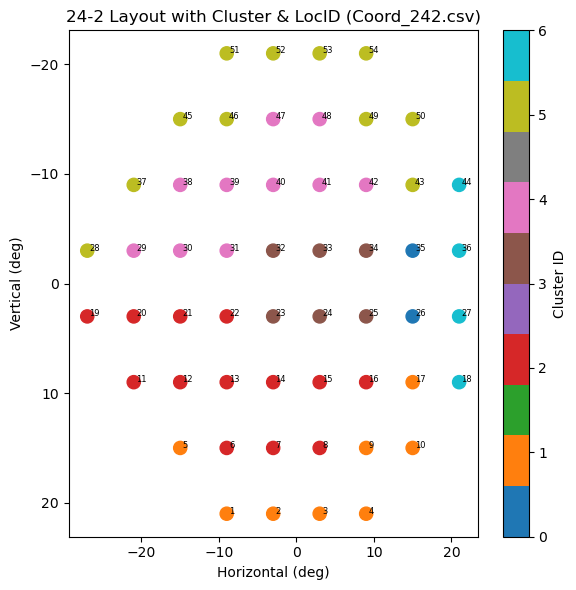

In [4]:
# === 4) Plot annotated layout with Cluster & LocID (if available) ===
if HAS_FULL:
    plt.figure(figsize=(6,6))
    sc = plt.scatter(coords_full["X"], coords_full["Y"], c=coords_full["Cluster"], s=90, cmap="tab10")
    for _, row in coords_full.iterrows():
        plt.text(row["X"]+0.3, row["Y"], str(int(row["LocID"])), fontsize=6)  # real LocID labels (match TD_*)
    plt.gca().invert_yaxis()
    plt.title("24-2 Layout with Cluster & LocID (Coord_242.csv)")
    plt.xlabel("Horizontal (deg)")
    plt.ylabel("Vertical (deg)")
    plt.colorbar(sc, label="Cluster ID")
    plt.tight_layout()
    plt.savefig(fig_dir / "layout_annotated_coord242.png", dpi=200)
    plt.show()

In [5]:
# === 5) Load model-ready tensors & meta just to plot one VF example ===
X = np.load(feat_dir / "X_td2ch_L52.npy")   # (N, 2, 52)
Y = np.load(feat_dir / "Y_td_L52.npy")      # (N, 52)
meta = pd.read_csv(proc_dir / "triplets_meta_L52.csv")

print("X:", X.shape, "Y:", Y.shape, "meta:", meta.shape)
display(meta.head())

X: (14117, 2, 52) Y: (14117, 52) meta: (14117, 14)


,PatID,Eye,v1_FieldN,v2_FieldN,v3_FieldN,Age_v1,Age_v2,Age_v3,MTD_v1,MTD_v2,MTD_v3,PSD_v1,PSD_v2,PSD_v3
0,1,Left,1,2,3,78.9432,84.3012,85.7577,-7.712115,-7.584231,-8.302115,6.304073,6.040501,4.802746
1,1,Left,2,3,4,84.3012,85.7577,86.8884,-7.584231,-8.302115,-11.586731,6.040501,4.802746,6.233109
2,1,Left,3,4,5,85.7577,86.8884,87.9425,-8.302115,-11.586731,-8.977308,4.802746,6.233109,5.397776
3,1,Left,4,5,6,86.8884,87.9425,89.2266,-11.586731,-8.977308,-7.713846,6.233109,5.397776,2.400569
4,1,Right,1,2,3,78.9432,84.3012,85.7577,-9.086346,-5.971538,-4.834423,4.915537,1.708727,4.395543


In [ ]:
# === 6) Voronoi image generator ===
import numpy as np

def generate_voronoi_images_given_image_size(data, xy_coordinates, image_size=(61, 61)):
    """
    Generate Voronoi images from per-location values and seed coordinates.

    Inputs:
        data:           (N, L) matrix — N samples, L locations (e.g., 52 TD values)
        xy_coordinates: (L, 2) array — seed coordinates (x, y) in degrees (right-eye ref)
        image_size:     output image size (rows, cols), default (61, 61)

    Outputs:
        vor_images:     (N, H, W) images
    """
    num_locs = xy_coordinates.shape[0]
    num_obs  = data.shape[0]

    # shift coordinates to image center
    x = xy_coordinates[:, 0].reshape(-1, 1)
    y = xy_coordinates[:, 1].reshape(-1, 1)
    x = x + int(image_size[0] / 2)
    y = y + int(image_size[1] / 2)
    voronoi_points = np.column_stack((x, y))

    # full pixel grid
    grid = np.mgrid[0:image_size[0], 0:image_size[1]]
    x_coord = grid[0, :].ravel()
    y_coord = grid[1, :].ravel()
    space_coordinates = np.vstack((x_coord, y_coord)).T

    H, W = image_size
    vor_images = np.zeros((num_obs, H, W), dtype=float)

    for k in range(num_obs):
        values = data[k, :]
        img = np.zeros((H, W), dtype=float)
        for col, row in space_coordinates:  # note: col=x, row=y
            dist = (voronoi_points[:, 0] - col) ** 2 + (voronoi_points[:, 1] - row) ** 2
            idx = np.argmin(dist)
            img[row, col] = values[idx]
        img = np.flipud(img)  # flip vertically to match VF plotting convention
        vor_images[k] = img

    return vor_images

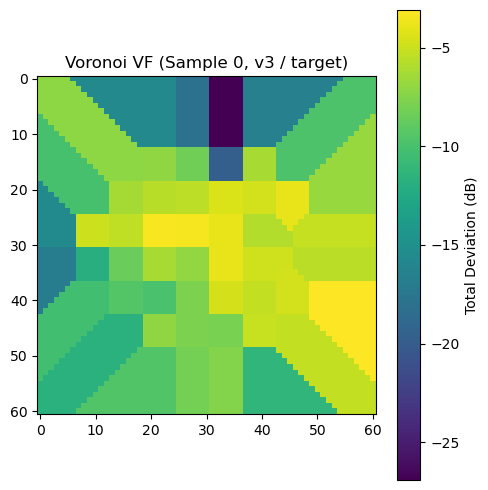

In [7]:
# === 7) Build (x,y) in the same order as the 52-length TD vector ===
# Our X/Y were built by removing blind spots TD_26 and TD_35 and keeping the remaining TD_1..TD_54 in numeric order.
# So the expected order is: [1..54] excluding [26, 35].

if HAS_FULL:
    # Filter non-blind locations and sort by LocID to match TD_1..TD_54 order
    nonblind = coords_full[coords_full["Cluster"] != 0].copy()
    nonblind = nonblind.sort_values("LocID")
    # Remove LocID 26 and 35 to align with L=52 tensors
    nonblind = nonblind[~nonblind["LocID"].isin([26, 35])]
    xy = nonblind[["X", "Y"]].to_numpy(dtype=float)  # (52, 2)

    # pick one sample to visualize (v3 = Y[i])
    i = 0
    v3 = Y[i]  # shape (52,)

    img = generate_voronoi_images_given_image_size(
        data=v3.reshape(1, -1),
        xy_coordinates=xy,
        image_size=(61, 61)
    )[0]

    plt.figure(figsize=(5,5))
    plt.imshow(img, origin="upper")
    plt.colorbar(label="Total Deviation (dB)")
    plt.title(f"Voronoi VF (Sample {i}, v3 / target)")
    plt.tight_layout()
    plt.savefig(fig_dir / f"vf_voronoi_sample_{i}_v3.png", dpi=200)
    plt.show()
else:
    print("Coord_242.csv not available — Voronoi with 52-point alignment is not reliable with p24d2 alone.")

In [23]:

def generate_voronoi_images_given_image_size(data, xy_coordinates, image_size=(61, 61)):
    """
    Generates voronoi images using given values for patching colors
    and given coordiantes for seed points.
    Here image size is fixed or given by the user.
    Inputs:
        data: NxL data matrix, N number of samples, L number of dimensions
        xy_coordinates: x- and y- coordinates of the seed points, Lx2  matrix
        image_size: (optional) the output image size
    Outputs:
        vor_images: NxRxC voronoi images, 3D tensor -- (number of samples N, number of rows R, number_of_columns C)
    """
    import numpy as np

    num_locs = xy_coordinates.shape[0]
    num_obs = data.shape[0]

    x = np.zeros((num_locs,1))
    y = np.zeros((num_locs,1))
    x[:,0] = xy_coordinates[:,0]
    y[:,0] = xy_coordinates[:,1]
    x = x + int(image_size[0]/2)
    y = y + int(image_size[1]/2)
    voronoi_points = np.column_stack((x,y))

    space_coordinates = np.mgrid[0:image_size[0], 0:image_size[1]]
    x_coord = space_coordinates[0, :].flatten() # columns
    y_coord = space_coordinates[1, :].flatten() # rows
    space_coordinates = np.vstack((x_coord,y_coord)).transpose()

    img_col_size = image_size[0]
    img_row_size = image_size[1]
    img = np.zeros((img_row_size, img_col_size))

    vor_images = np.zeros((num_obs, img_row_size, img_col_size))
    for k in range(num_obs):
        value_vector = data[k,:]
        for img_col_ind, img_row_ind in space_coordinates:
            dist = (voronoi_points[:, 0] - img_col_ind)**2 + (voronoi_points[:,1] - img_row_ind)**2
            idx = np.argmin(dist)
            img[img_row_ind, img_col_ind] = value_vector[idx]

        # flip vertically to match VF plotting convention
        img = np.flipud(img)
        vor_images[k, :, :] = img

    return vor_images

In [ ]:

def extract_td_1_54(row):
    td_cols = [f"TD_{i}" for i in range(1, 55)]
    return row[td_cols].to_numpy(dtype=float)


def fill_nan_sample_median(v):
    if np.isnan(v).any():
        med = np.nanmedian(v)
        v = np.where(np.isnan(v), med, v)
    return v

def build_xy_for_eye(coords_df, eye: str):
    cols_lower = {c.lower(): c for c in coords_df.columns}
    xcol, ycol = cols_lower.get("x"), cols_lower.get("y")
    assert xcol and ycol, f"p24d2 must have x,y columns; got {coords_df.columns.tolist()}"
    xy = coords_df[[xcol, ycol]].to_numpy(dtype=float)  # right-eye coords
    if eye.strip().lower().startswith("l"):             # left eye → flip x
        xy = xy.copy()
        xy[:, 0] = -xy[:, 0]
    return xy

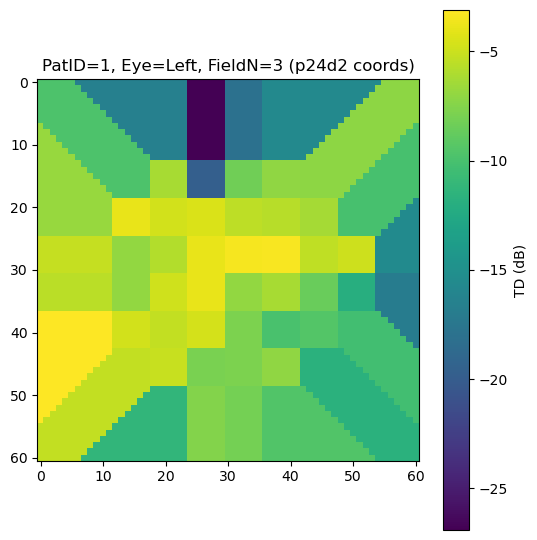

In [ ]:

def visualize_single_vf_p24(patid:int, eye:str, fieldn:int, image_size=(61,61), cmap="viridis"):
    mask = (vf["PatID"]==patid) & (vf["Eye"].str.lower()==eye.lower()) & (vf["FieldN"]==fieldn)
    assert mask.any(), f"No row for PatID={patid}, Eye={eye}, FieldN={fieldn}"
    row = vf.loc[mask].iloc[0]

    td = extract_td_1_54(row)
    td = fill_nan_sample_median(td)   # just for plotting

    xy = build_xy_for_eye(coords, eye)

    img = generate_voronoi_images_given_image_size(td.reshape(1,-1), xy, image_size=image_size)[0]

    plt.figure(figsize=(5.5,5.5))
    plt.imshow(img, origin="upper", cmap=cmap)  
    plt.colorbar(label="TD (dB)")
    plt.title(f"PatID={patid}, Eye={eye}, FieldN={fieldn} (p24d2 coords)")
    plt.tight_layout()
    plt.show()


visualize_single_vf_p24(1, "Left", 3) #example

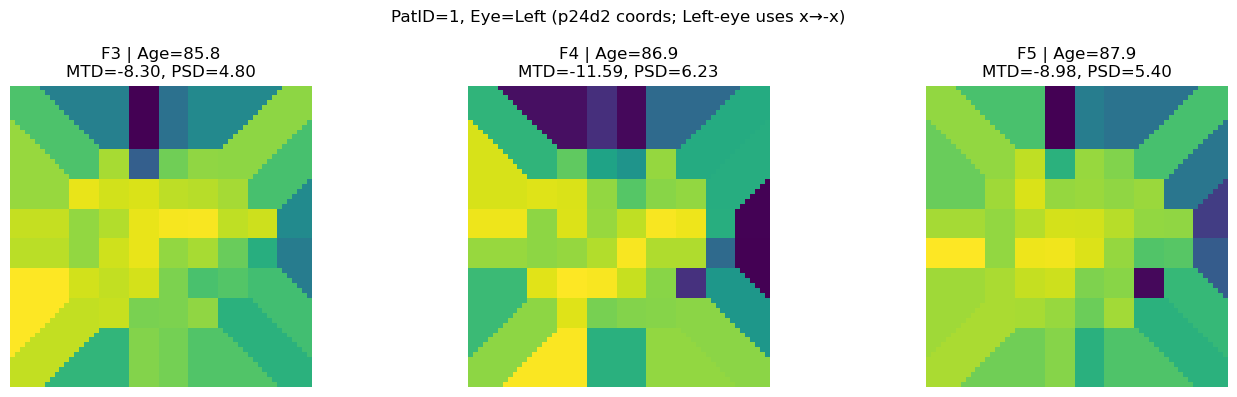

In [44]:

def visualize_triplet_p24(patid:int, eye:str, fieldns:list, image_size=(61,61), cmap="viridis"):
    assert len(fieldns)==3, "fieldns should be [F1, F2, F3]"
    xy = build_xy_for_eye(coords, eye)

    imgs, metas = [], []
    for f in fieldns:
        m = (vf["PatID"]==patid) & (vf["Eye"].str.lower()==eye.lower()) & (vf["FieldN"]==f)
        assert m.any(), f"No row for PatID={patid}, Eye={eye}, FieldN={f}"
        row = vf.loc[m].iloc[0]
        td = fill_nan_sample_median(extract_td_1_54(row))
        img = generate_voronoi_images_given_image_size(td.reshape(1,-1), xy, image_size=image_size)[0]
        imgs.append(img); metas.append(row)

    plt.figure(figsize=(14,4))
    for i, (img, row) in enumerate(zip(imgs, metas), 1):
        plt.subplot(1,3,i)
        plt.imshow(img, origin="upper", cmap=cmap)
        plt.title(f"F{int(row['FieldN'])} | Age={row['Age']:.1f}\nMTD={row['MTD']:.2f}, PSD={row['PSD']:.2f}")
        plt.axis("off")
    plt.suptitle(f"PatID={patid}, Eye={eye} (p24d2 coords; Left-eye uses x→-x)")
    plt.tight_layout()
    plt.show()

# Example：
visualize_triplet_p24(1, "Left", [3,4,5])